<a href="https://colab.research.google.com/github/ArchisKulkarni002/RansomwareMLProject/blob/main/Ransomware_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec  as gridspec
import matplotlib.ticker as mticker
import warnings
from IPython.display import display, HTML
import ipaddress

# Suppress all warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_seq_items', None)
pd.set_option('display.expand_frame_repr', False)

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
data_path = '/content/drive/MyDrive/Android_Ransomeware.csv'
ransomware_df = pd.read_csv(data_path)

#EDA and PreProcessing

In [120]:
#defining color palettes
ransomware_palette = sns.color_palette("Set1", 11)
protocol_palette =  {'Reserved': sns.color_palette("muted")[1],  # muted orange
                    'TCP': sns.color_palette("muted")[0],       # muted blue
                    'UDP': sns.color_palette("muted")[2]}

In [121]:
ransomware_df.columns = ransomware_df.columns.str.strip()
# ransomware_df = ransomware_df.sample(n=50000, seed=42)

In [122]:
print(ransomware_df.head(5))

   Index                                 Flow ID    Source IP  Source Port  Destination IP  Destination Port  Protocol         Timestamp  Flow Duration  Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std   Flow Bytes/s  Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  Min Packet Length  Max Packet Length  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  SYN Flag Count  RST Flag Count  PSH Flag Count  ACK Flag Count  URG Flag Count  CWE Flag Co

In [123]:
#printing shape of ransomware df
df_row_count, df_column_count = ransomware_df.shape
print("rows = ", df_row_count, " cols = ", df_column_count)

rows =  392034  cols =  86


In [124]:
def summarize_dataframe(df):
    # Initialize an empty list to store summary data for each column
    summary_data = []

    # Loop through each column to get dtype, null count, distinct count, and additional statistics
    for col in df.columns:
        dtype = df[col].dtype
        null_count = df[col].isnull().sum()
        distinct_count = df[col].nunique()

        # Dictionary to store summary data for this column
        col_summary = {
            'Column': col.strip(),
            'Data Type': dtype,
            'Total Count': df_row_count,
            'Total Distinct': distinct_count,
            'Null Count': null_count

        }

        # Calculate stats based on data type
        if pd.api.types.is_numeric_dtype(df[col]):
            col_summary['Mean'] = df[col].mean()
            col_summary['Median'] = df[col].median()
            col_summary['Max'] = df[col].max()
            col_summary['Min'] = df[col].min()
            col_summary['Std_Dev'] = df[col].std()
        elif pd.api.types.is_object_dtype(df[col]):
            col_summary['Mode'] = df[col].mode().iloc[0] if not df[col].mode().empty else None
        else:
            col_summary['Mean'] = col_summary['Median'] = col_summary['Max'] = col_summary['Min'] = col_summary['Std_Dev'] = None
            col_summary['Mode'] = None

        # Append the column summary to the list
        summary_data.append(col_summary)

    return summary_data





In [125]:
summary_df = pd.DataFrame(summarize_dataframe(ransomware_df))

display(HTML(summary_df.to_html(max_rows=100, max_cols=None)))

In [126]:
#Dropping the index columns
processed_ransomware_df = ransomware_df.drop(['Index', 'Flow ID' ], axis=1, inplace=False)

In [127]:
#columnns with only single value
single_valued_cols = summary_df.loc[summary_df['Total Distinct'] == 1, 'Column'].tolist()
print(single_valued_cols)

#Dropping the single valued columns
processed_ransomware_df = processed_ransomware_df.drop(single_valued_cols, axis=1, inplace=False)
summary_df = pd.DataFrame(summarize_dataframe(processed_ransomware_df))

display(HTML(summary_df.to_html(max_rows=100, max_cols=None)))

['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'RST Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


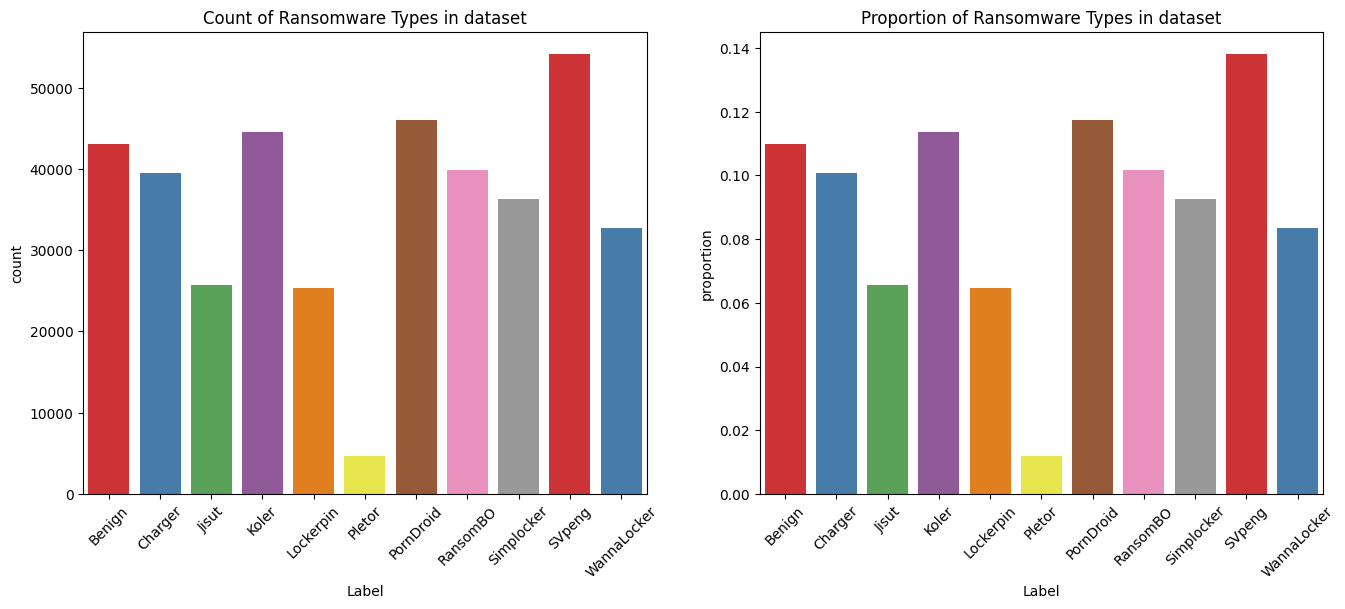

In [128]:
# plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=processed_ransomware_df, x='Label', ax = axes[0], palette=ransomware_palette)
axes[0].set_title('Count of Ransomware Types in dataset')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.countplot(data=processed_ransomware_df, x='Label', ax = axes[1], stat='proportion', palette=ransomware_palette)
axes[1].set_title('Proportion of Ransomware Types in dataset')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.show()

In [129]:
def is_private_ip(ip):
    try:
      ip_obj = ipaddress.ip_address(ip)

      if ip_obj.is_private:
          return 'private'
      elif ip_obj.is_loopback:
          return 'loopback'
      elif ip_obj.is_link_local:
          return 'link_local'
      elif ip_obj.is_multicast:
          return 'multicast'
      else:
          return 'public'
    except ValueError:
        return None

processed_ransomware_df['Source_IP_type'] = processed_ransomware_df['Source IP'].apply(is_private_ip)
processed_ransomware_df['Destination_IP_type'] = processed_ransomware_df['Destination IP'].apply(is_private_ip)



ip_type_summary_df = pd.DataFrame(summarize_dataframe(processed_ransomware_df[['Source_IP_type', 'Destination_IP_type']]))
display(HTML(ip_type_summary_df.to_html(max_rows=100, max_cols=None)))

In [130]:
# Drop the source IP and destination IP
processed_ransomware_df.drop('Source IP' , axis=1, inplace=True)
processed_ransomware_df.drop('Destination IP' , axis=1, inplace=True)

print(processed_ransomware_df.columns)



Index(['Source Port', 'Destination Port', 'Protocol', 'Timestamp',
       'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Co

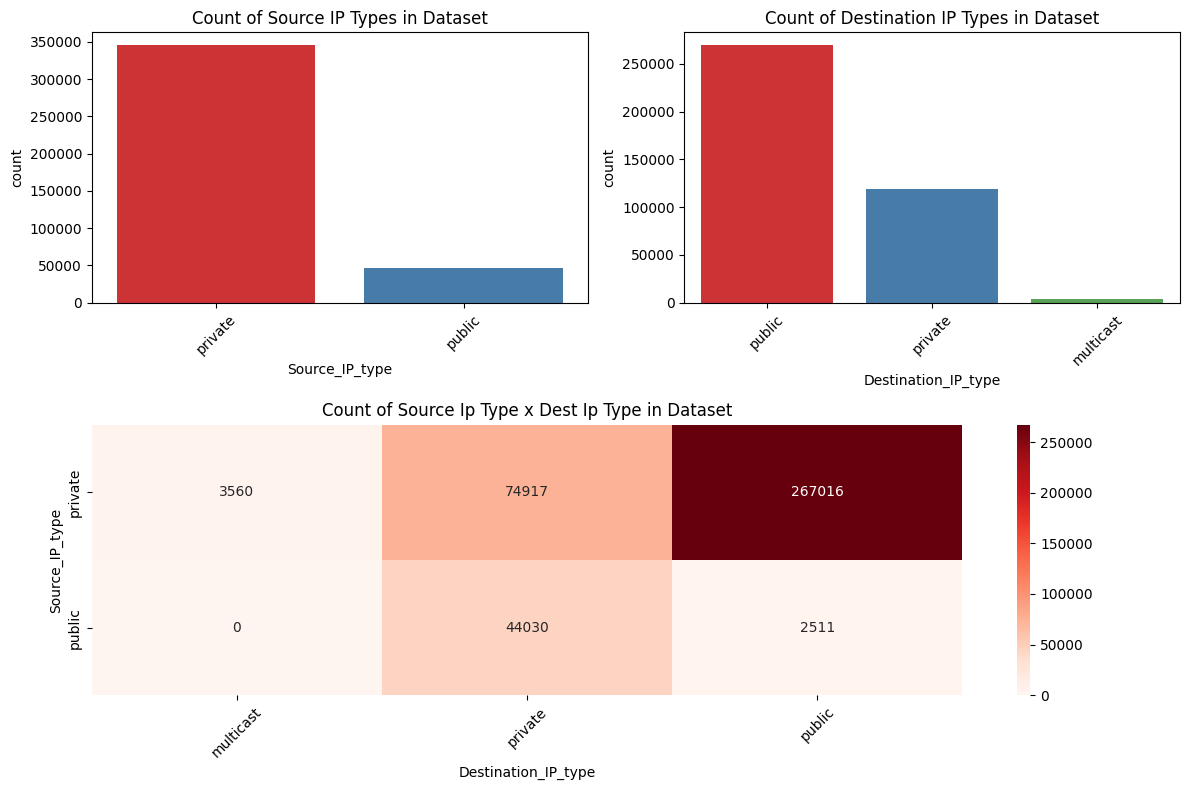

In [131]:
# Define figure and gridspec layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Top-left plot
ax1 = fig.add_subplot(gs[0, 0])
sns.countplot(data=processed_ransomware_df, x='Source_IP_type', ax=ax1, palette=ransomware_palette)
ax1.set_title('Count of Source IP Types in Dataset')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Top-right plot
ax2 = fig.add_subplot(gs[0, 1])
sns.countplot(data=processed_ransomware_df, x='Destination_IP_type', ax=ax2, palette=ransomware_palette)
ax2.set_title('Count of Destination IP Types in Dataset')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Bottom-wide plot, spanning both columns
ax3 = fig.add_subplot(gs[1, :])
contingency_table = pd.crosstab(processed_ransomware_df['Source_IP_type'], processed_ransomware_df['Destination_IP_type'])
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Reds', ax=ax3)

ax3.set_title('Count of Source Ip Type x Dest Ip Type in Dataset')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [132]:
def chi2_calculator( col1, col2):
  # Calculate the Chi-square statistic
    chi2 = 0
    contingency_table = pd.crosstab(col1, col2)


    n = contingency_table.sum().sum()  # Total number of observations

    # Calculate expected frequencies
    row_totals = contingency_table.sum(axis=1).values.reshape(-1, 1)
    col_totals = contingency_table.sum(axis=0).values.reshape(1, -1)
    expected = (row_totals @ col_totals) / n  # Expected frequency for each cell



    # Compute Chi-square by summing (Observed - Expected)^2 / Expected
    chi2 = ((contingency_table - expected) ** 2 / expected).to_numpy().sum()

    return chi2, (row_totals.shape[0]-1)*(col_totals.shape[1]-1) # returns chi2, degree for freedom (r-1)*(c-1)

#Corrected Cramers https://stats.lse.ac.uk/bergsma/pdf/cramerV3.pdf
def cramers_v(col1, col2):

    # Step 1: Create a contingency table
    contingency_table = pd.crosstab(col1, col2)
    n = contingency_table.sum().sum()
    # Step 2: Calculate the Chi-square statistic
    chi2, chi_df = chi2_calculator(col1, col2)
    phi2 = chi2 / n

    r, c = contingency_table.shape
    #corrected phi2
    phi2 = max(0, phi2 - ((c-1)*(r-1)/(n-1)))

    r = r - ((r -1)**2/(n-1))
    c = c - ((c -1)**2/(n-1))


    # Step 3: Calculate Cramér's V

    cramers_v = np.sqrt(phi2 / (min(r-1, c-1)))

    return cramers_v

In [133]:
#cramer v for source port and label

sample_df = processed_ransomware_df[['Source Port', 'Label']]  # Adjust 'n' as needed
cvalue_s_port_label = cramers_v(sample_df['Source Port'], sample_df['Label'])
print("cramers v  for source_port and label = ", cvalue_s_port_label)

#cramers v for destination port and label
sample_df = processed_ransomware_df[['Destination Port', 'Label']]  # Adjust 'n' as needed
cvalue_d_port_label = cramers_v(sample_df['Destination Port'], sample_df['Label'])
print("cramers v  for Destination port and label = ", cvalue_d_port_label)


#cramers v for source and destination port pair v label
sample_df = pd.DataFrame()

sample_df['Source_Destination_port'] = processed_ransomware_df['Source Port'].astype(str) + '-' + processed_ransomware_df['Destination Port'].astype(str)
sample_df['Label'] = processed_ransomware_df['Label']
cvalue_s_d_port_label = cramers_v(sample_df['Source_Destination_port'], sample_df['Label'] )
print("cramers v  for Source-Destination port and label = ", cvalue_s_d_port_label)

#cramer v for source and destination port // Computationally too heavy

# sample_df = processed_ransomware_df[['Destination Port', 'Source Port']].sample(50000, random_state=42)
# # contingency_table = pd.crosstab(sample_df['col1'], sample_df['col2'])
# cvalue_sd_port_label = cramers_v(sample_df['Destination Port'], sample_df['Source Port'])
# print("cramers v  for Destination port and Source Port = ", cvalue_sd_port_label)

cramers v  for source_port and label =  0.28716033347813036
cramers v  for Destination port and label =  0.1975902954430126
cramers v  for Source-Destination port and label =  0.41845675289081613


### Observation

- Source Port and Ransomware Type has ~0.29 association; **Weak to Moderate** association

- Destination Port and Ransomware Type has ~0.19 association: **Weak** association

- Source-Destination Port Pair and Ransomware Type has ~0.42 assocition: **Moderate** associtation

Based on this we cannot drop the port table, as they have moderate assocation with ransomware type , when taken pair wise,  we may need further analysis, to drop the columns.

In [134]:
protocol_mapping = {
    0: 'Reserved',
    1: 'ICMP',              # Internet Control Message Protocol
    6: 'TCP',               # Transmission Control Protocol
    17: 'UDP',              # User Datagram Protocol
}

# Map protocol numbers to protocol names
processed_ransomware_df['Protocol'] = processed_ransomware_df['Protocol'].map(protocol_mapping)

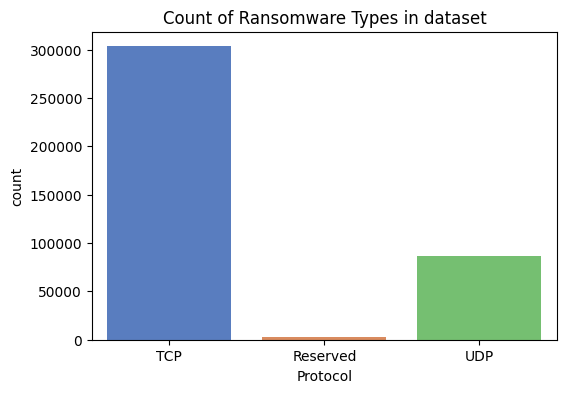

In [135]:
plt.figure(figsize=(6, 4))
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=processed_ransomware_df, x='Protocol', palette=protocol_palette)
plt.title('Count of Ransomware Types in dataset')
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

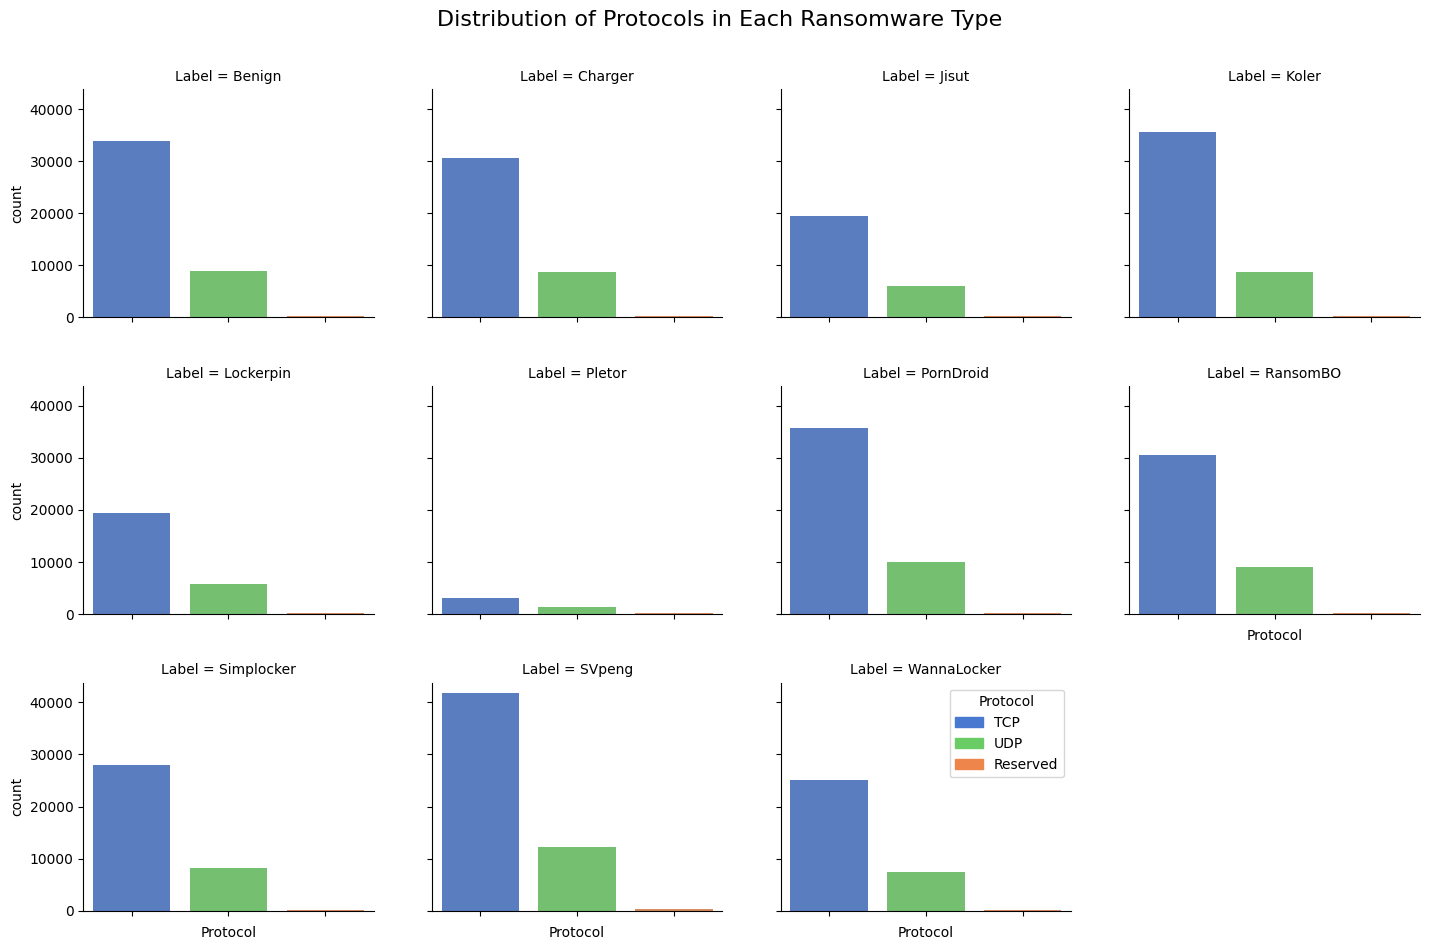

In [136]:
plt.figure(figsize=(12, 8))
grid = sns.FacetGrid(data=processed_ransomware_df, col='Label',height=3, aspect=1.2, col_wrap=4)

grid.map(sns.countplot, 'Protocol', order=['TCP', 'UDP', 'Reserved'], palette = protocol_palette)

# # grid.fig.suptitle('Count of Each Weekday in Each Cluster', y=1.05, fontsize=16

for i, ax in enumerate(grid.axes.flat):
  if i>=3:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Adjust layout to avoid overlap
plt.tight_layout()
grid.fig.subplots_adjust(hspace=0.3, wspace=0.2)
grid.fig.suptitle('Distribution of Protocols in Each Ransomware Type', y=1.05, fontsize=16)
grid.add_legend()
import matplotlib.patches as mpatches
legend_handles = [
  mpatches.Patch(color=sns.color_palette("muted")[0], label='TCP'),      # muted blue
    mpatches.Patch(color=sns.color_palette("muted")[2], label='UDP'),      # muted green
    mpatches.Patch(color=sns.color_palette("muted")[1], label='Reserved')  # muted orange

]

# Add the custom legend to the grid
plt.legend(handles=legend_handles, title="Protocol", loc="upper right")
# Show the plot
plt.show()

['Fwd PSH Flags', 'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count']


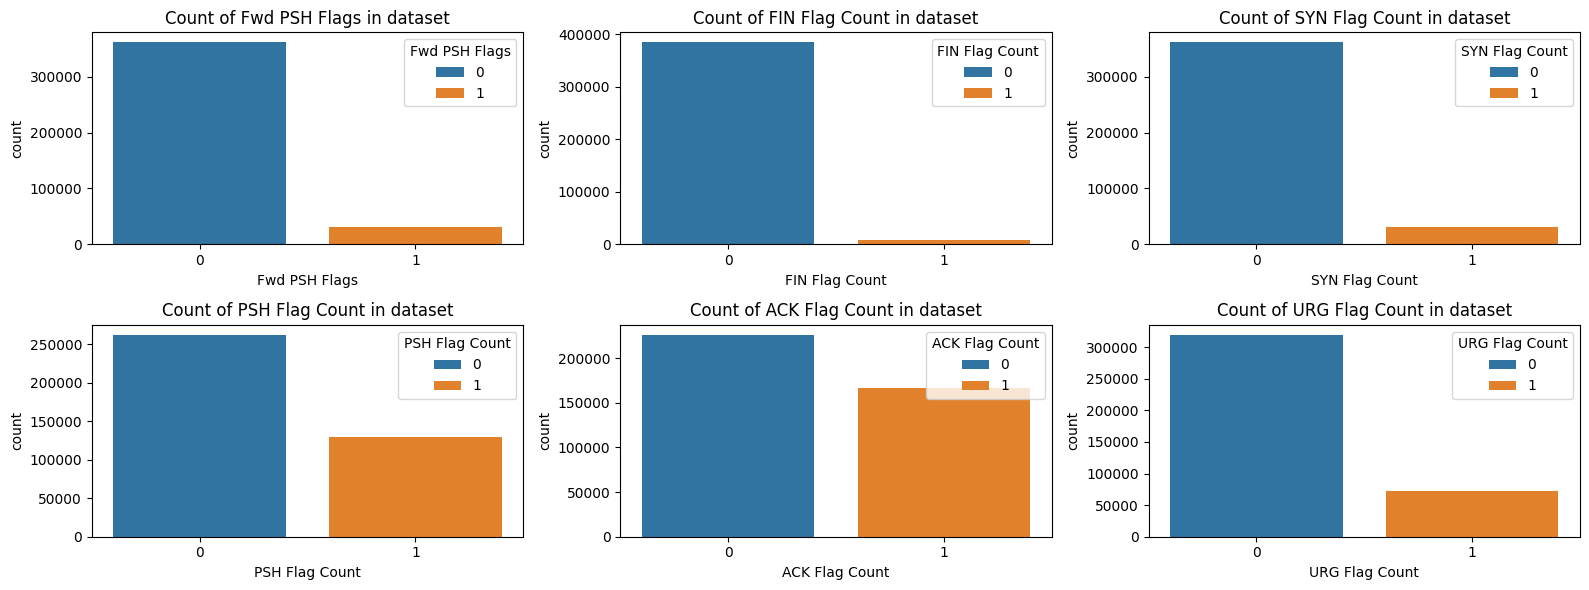

In [137]:
double_valued_cols = summary_df.loc[summary_df['Total Distinct'] == 2, 'Column'].tolist()
if 'Source_IP_type' in double_valued_cols:
    double_valued_cols.remove('Source_IP_type')
print(double_valued_cols)

num_cols = 3
num_rows = (len(double_valued_cols) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6), squeeze=False)

# Plot each column in double_valued_cols
for i, col in enumerate(double_valued_cols):
    row, col_index = divmod(i, num_cols)  # Determine row and column position
    sns.countplot(data=processed_ransomware_df, x=col, ax=axes[row, col_index], hue=col)
    axes[row, col_index].set_title(f'Count of {col} in dataset')

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    row, col_index = divmod(j, num_cols)
    axes[row, col_index].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [138]:
def calculate_cramer_matrix(df, categorical_cols=[], exclude_pairs=[]) :


  cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

  # Calculate Cramér's V only for upper triangular matrix
  for i, col1 in enumerate(categorical_cols):
      for j, col2 in enumerate(categorical_cols):
          if j == i :
            cramers_v_matrix.loc[col1, col2] = 1.0
          elif j > i:  # Only compute for upper triangular part
              # Skip calculation if the pair is in exclude_pairs
              if {col1, col2} in exclude_pairs :
                  cramers_v_matrix.loc[col1, col2] = np.NaN  # Mark as NaN or None if excluded
              else:
                  cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])  # Calculate Cramér's V
              cramers_v_matrix.loc[col2, col1] = cramers_v_matrix.loc[col1, col2]  # Mirror value

  # Fill diagonal with 1.0 (self-correlation)
  # for col in categorical_cols:
  #     cramers_v_matrix.loc[col, col] = 1.0

  # Convert matrix to numeric type for heatmap compatibility
  cramers_v_matrix = cramers_v_matrix.astype(float)
  return cramers_v_matrix




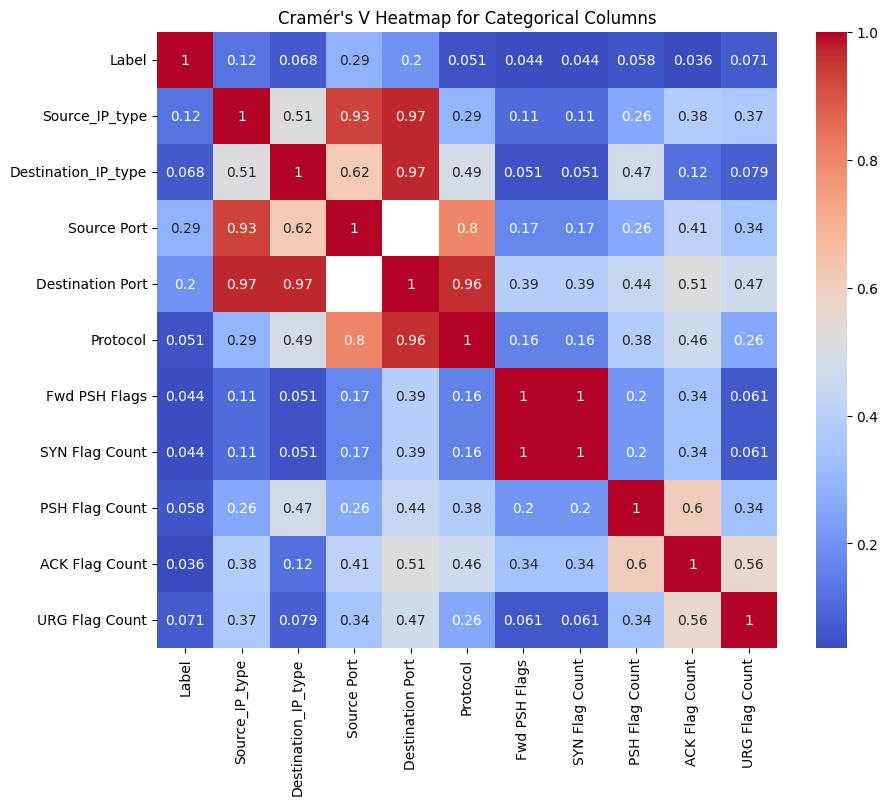

In [139]:
  # Plot the heatmap

categorical_cols = ['Label','Source_IP_type', 'Destination_IP_type','Source Port','Destination Port', 'Protocol',  'Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count' , 'ACK Flag Count', 'URG Flag Count']
exclude_pairs = [{'Source Port', 'Destination Port'}]

cramers_matrix = calculate_cramer_matrix(processed_ransomware_df, categorical_cols, exclude_pairs)
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm")
plt.title("Cramér's V Heatmap for Categorical Columns")
plt.show()


SYN Flag Count to be deleted

In [140]:
categorical_cols.remove('SYN Flag Count')

In [141]:
numerical_cols = [item for item in processed_ransomware_df if item not in categorical_cols]
numerical_cols.remove('Timestamp')
# print(numerical_cols)
for col in numerical_cols:
  print (col)



Flow Duration
Total Fwd Packets
Total Backward Packets
Total Length of Fwd Packets
Total Length of Bwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Min Packet Length
Max Packet Length
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
Down/Up Ratio
Average Packet Size
Avg Fwd Segment Size
Avg Bwd Segment Size
Fwd Header Length.1
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
Init_Win_bytes_forward
Init_Win_bytes_backward
act_data_pkt_fwd
min_seg_size_forward
Active Mean
Active Std
Active Max
Active Min
Idle Mean
Id

12


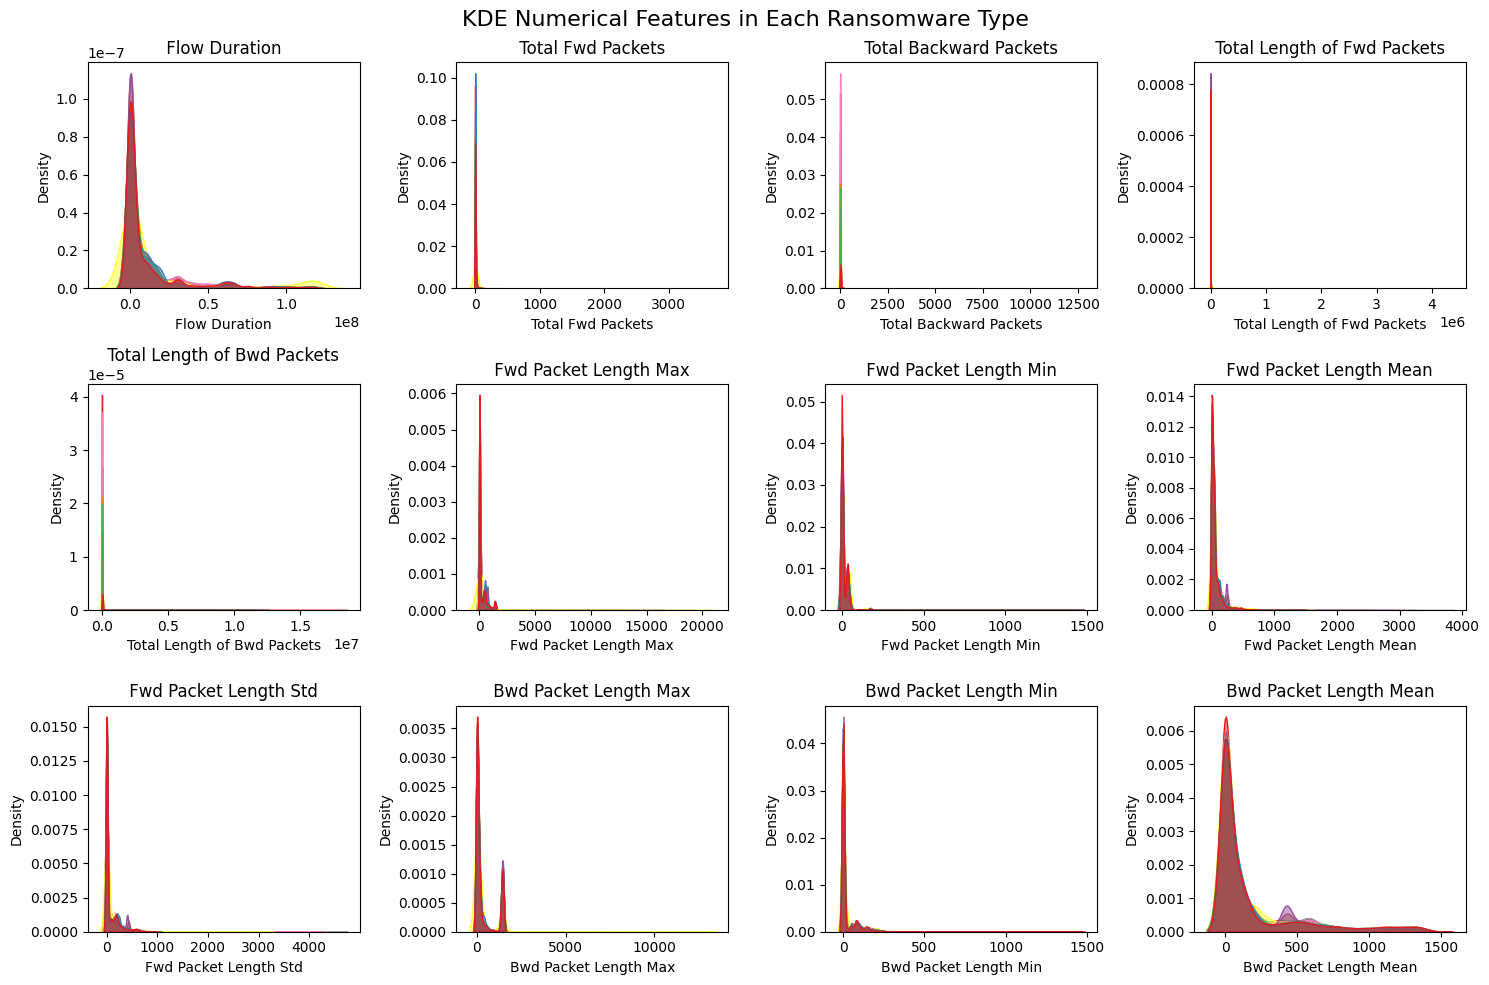

In [142]:
numerical_cols1 = numerical_cols[:12]
print(len(numerical_cols1))
num_cols = 4
num_rows = (len(numerical_cols1) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), squeeze=False)

# Plot each column in double_valued_cols
for i, col in enumerate(numerical_cols1):
    row, col_index = divmod(i, num_cols)  # Determine row and column position
    sns.kdeplot(data=processed_ransomware_df, x=col, ax=axes[row, col_index], hue='Label', palette = ransomware_palette, fill = True, alpha = 0.5, common_norm=False)
    axes[row, col_index].set_title(f' {col} ')
    axes[row, col_index].legend().set_visible(False)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    row, col_index = divmod(j, num_cols)
    axes[row, col_index].axis('off')

# Adjust layout
fig.suptitle('KDE Numerical Features in Each Ransomware Type', fontsize=16)
plt.tight_layout()
plt.show()

12


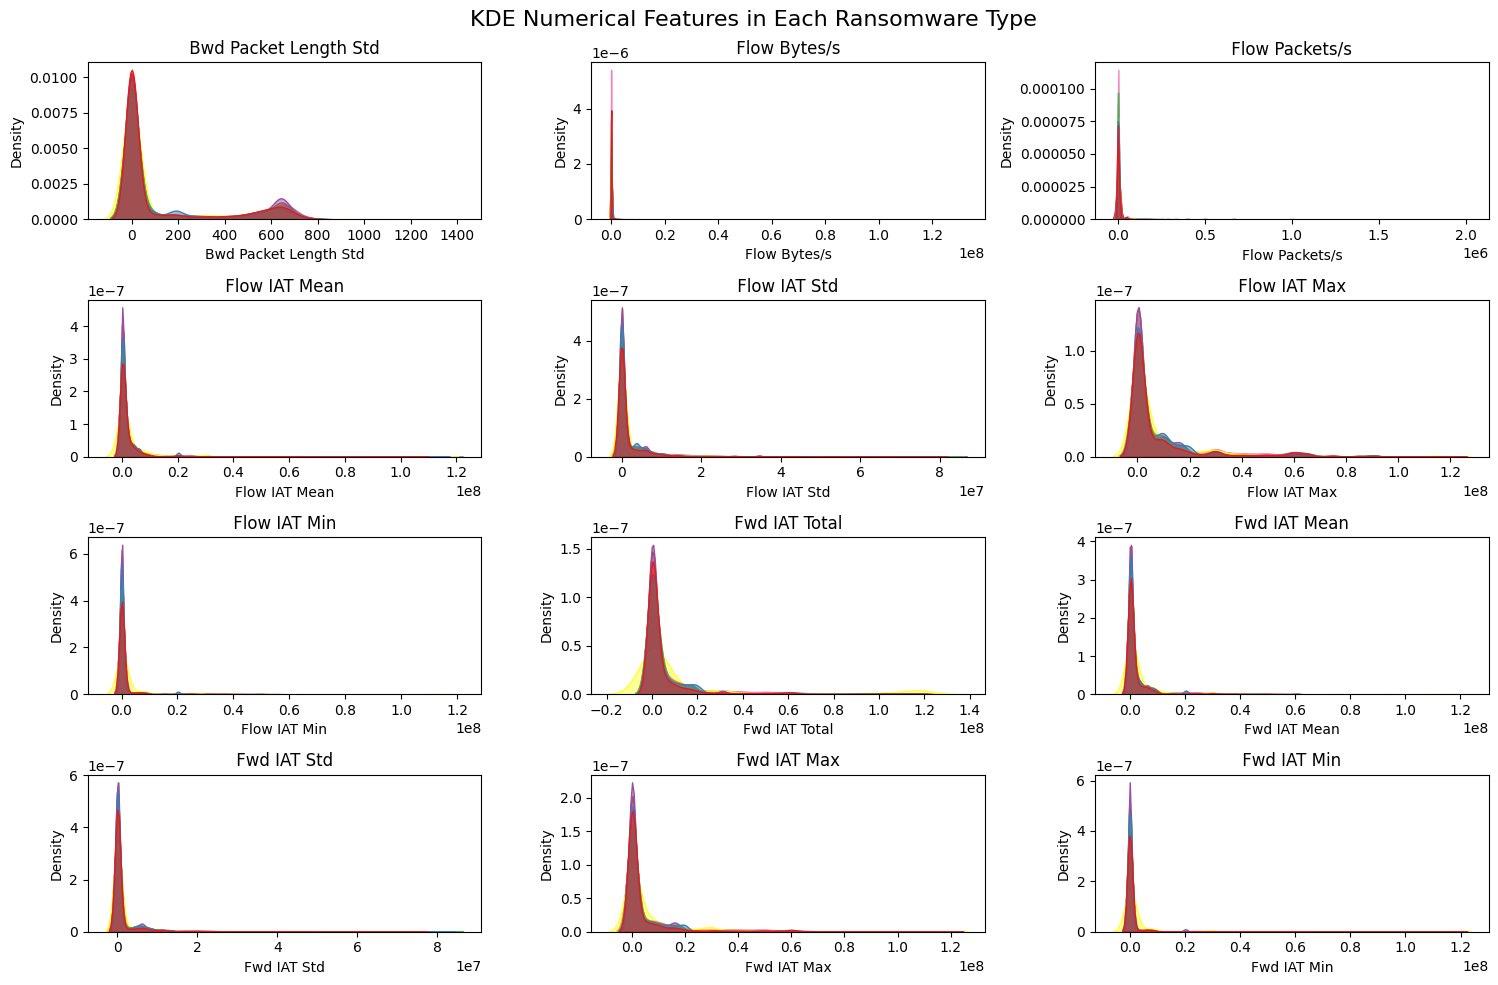

In [143]:
numerical_cols1 = numerical_cols[12:24]
print(len(numerical_cols1))
num_cols = 3
num_rows = (len(numerical_cols1) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), squeeze=False)

# Plot each column in double_valued_cols
for i, col in enumerate(numerical_cols1):
    row, col_index = divmod(i, num_cols)  # Determine row and column position
    sns.kdeplot(data=processed_ransomware_df, x=col, ax=axes[row, col_index], hue='Label', palette = ransomware_palette, fill = True, alpha = 0.5, common_norm=False)
    axes[row, col_index].set_title(f' {col} ')
    axes[row, col_index].legend().set_visible(False)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    row, col_index = divmod(j, num_cols)
    axes[row, col_index].axis('off')

# Adjust layout
fig.suptitle('KDE Numerical Features in Each Ransomware Type', fontsize=16)
plt.tight_layout()
plt.show()

12


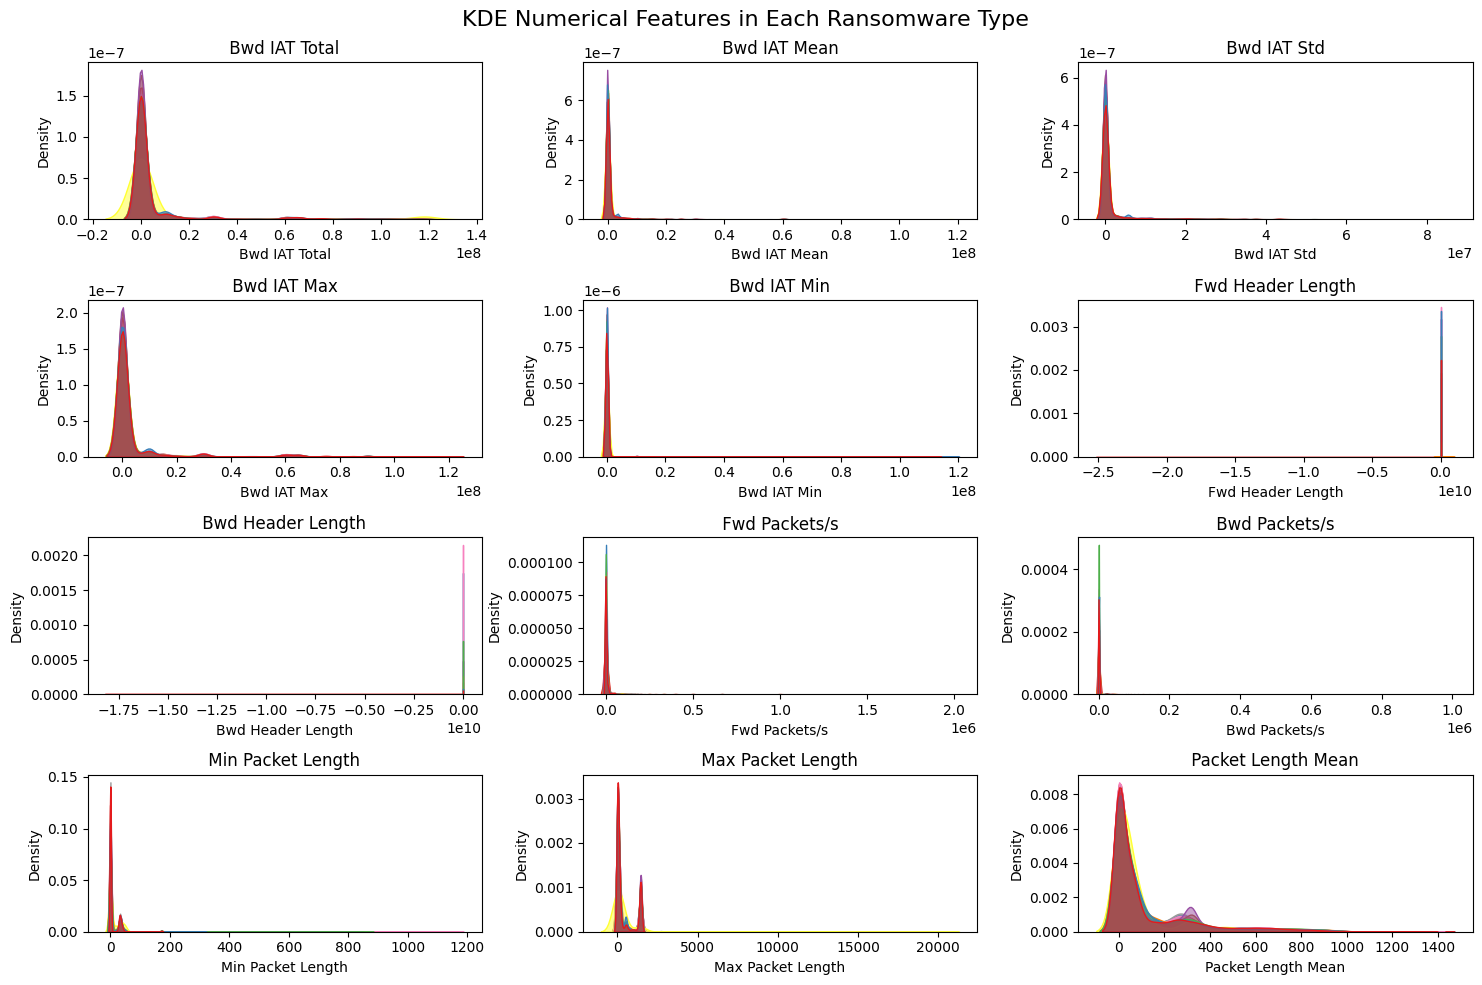

In [144]:
numerical_cols1 = numerical_cols[24:36]
print(len(numerical_cols1))
num_cols = 3
num_rows = (len(numerical_cols1) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), squeeze=False)

# Plot each column in double_valued_cols
for i, col in enumerate(numerical_cols1):
    row, col_index = divmod(i, num_cols)  # Determine row and column position
    sns.kdeplot(data=processed_ransomware_df, x=col, ax=axes[row, col_index], hue='Label', palette = ransomware_palette, fill = True, alpha = 0.5, common_norm=False)
    axes[row, col_index].set_title(f' {col} ')
    axes[row, col_index].legend().set_visible(False)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    row, col_index = divmod(j, num_cols)
    axes[row, col_index].axis('off')

# Adjust layout
fig.suptitle('KDE Numerical Features in Each Ransomware Type', fontsize=16)
plt.tight_layout()
plt.show()

12


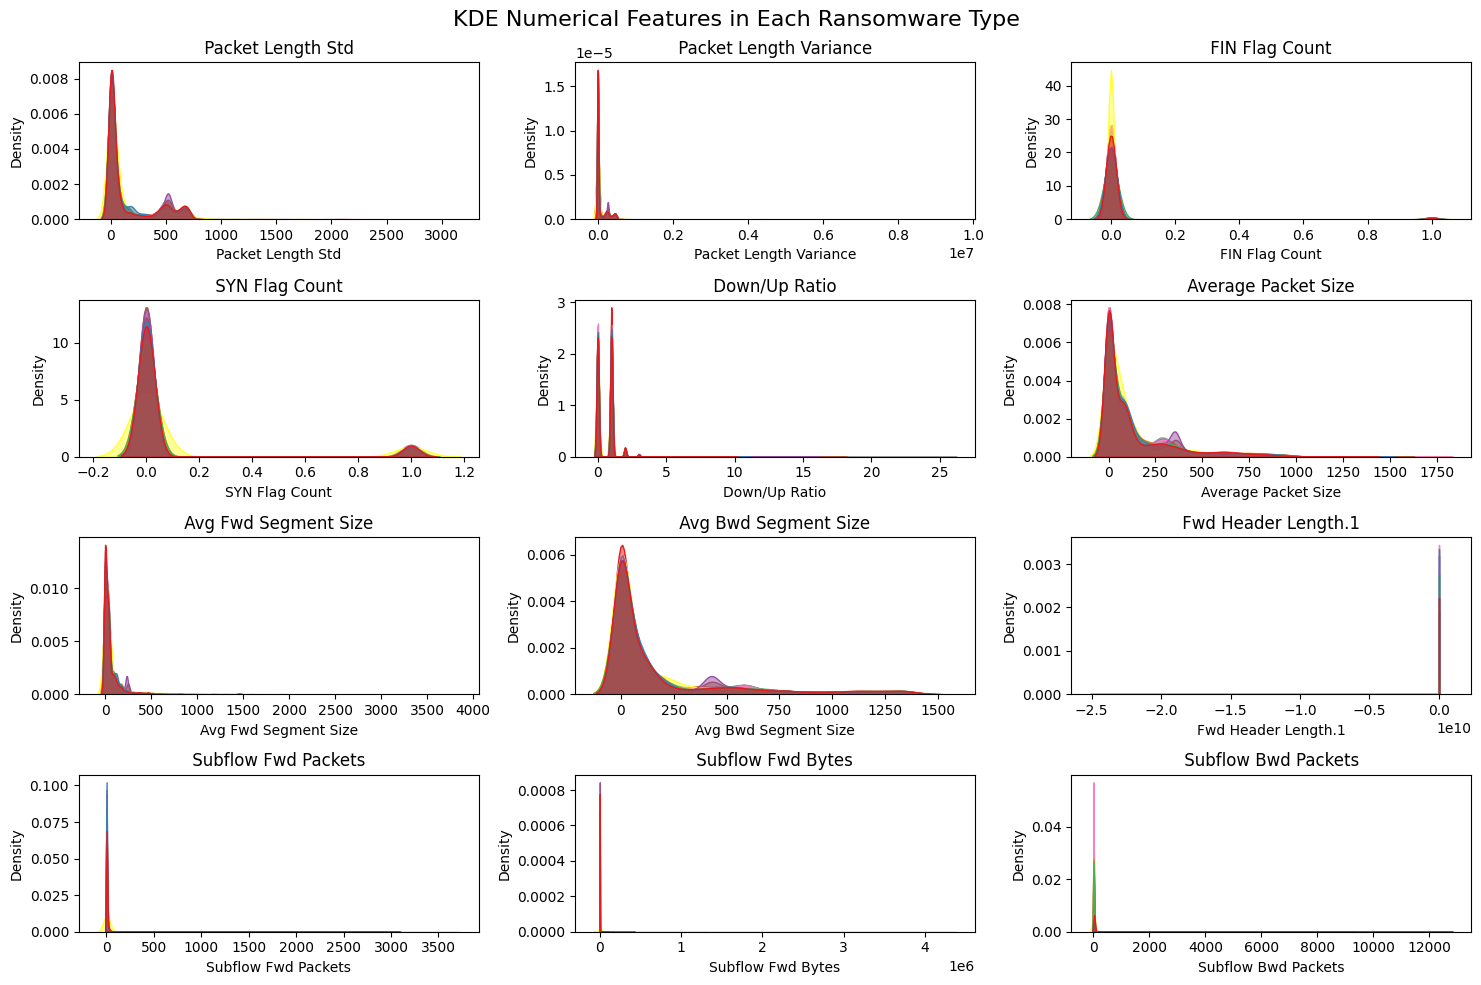

In [145]:
numerical_cols1 = numerical_cols[36:48]
print(len(numerical_cols1))
num_cols = 3
num_rows = (len(numerical_cols1) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), squeeze=False)

# Plot each column in double_valued_cols
for i, col in enumerate(numerical_cols1):
    row, col_index = divmod(i, num_cols)  # Determine row and column position
    sns.kdeplot(data=processed_ransomware_df, x=col, ax=axes[row, col_index], hue='Label', palette = ransomware_palette, fill = True, alpha = 0.5, common_norm=False)
    axes[row, col_index].set_title(f' {col} ')
    axes[row, col_index].legend().set_visible(False)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    row, col_index = divmod(j, num_cols)
    axes[row, col_index].axis('off')

# Adjust layout
fig.suptitle('KDE Numerical Features in Each Ransomware Type', fontsize=16)
plt.tight_layout()
plt.show()

12


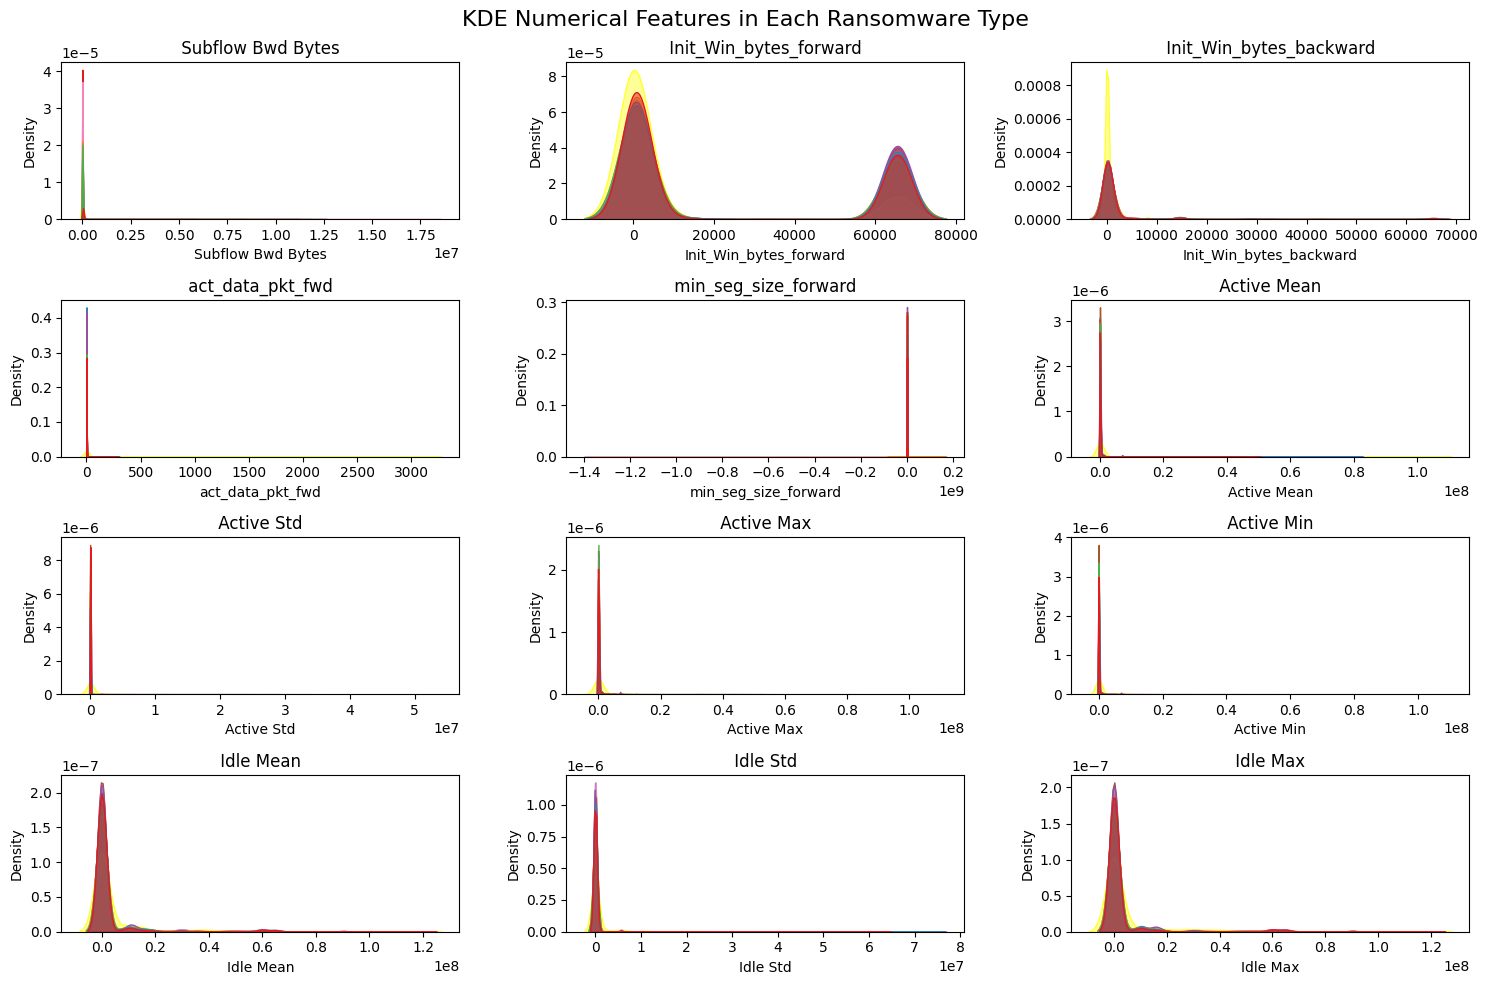

In [146]:
numerical_cols1 = numerical_cols[48:60]
print(len(numerical_cols1))
num_cols = 3
num_rows = (len(numerical_cols1) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), squeeze=False)

# Plot each column in double_valued_cols
for i, col in enumerate(numerical_cols1):
    row, col_index = divmod(i, num_cols)  # Determine row and column position
    sns.kdeplot(data=processed_ransomware_df, x=col, ax=axes[row, col_index], hue='Label', palette = ransomware_palette, fill = True, alpha = 0.5, common_norm=False)
    axes[row, col_index].set_title(f' {col} ')
    axes[row, col_index].legend().set_visible(False)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    row, col_index = divmod(j, num_cols)
    axes[row, col_index].axis('off')

# Adjust layout
fig.suptitle('KDE Numerical Features in Each Ransomware Type', fontsize=16)
plt.tight_layout()
plt.show()

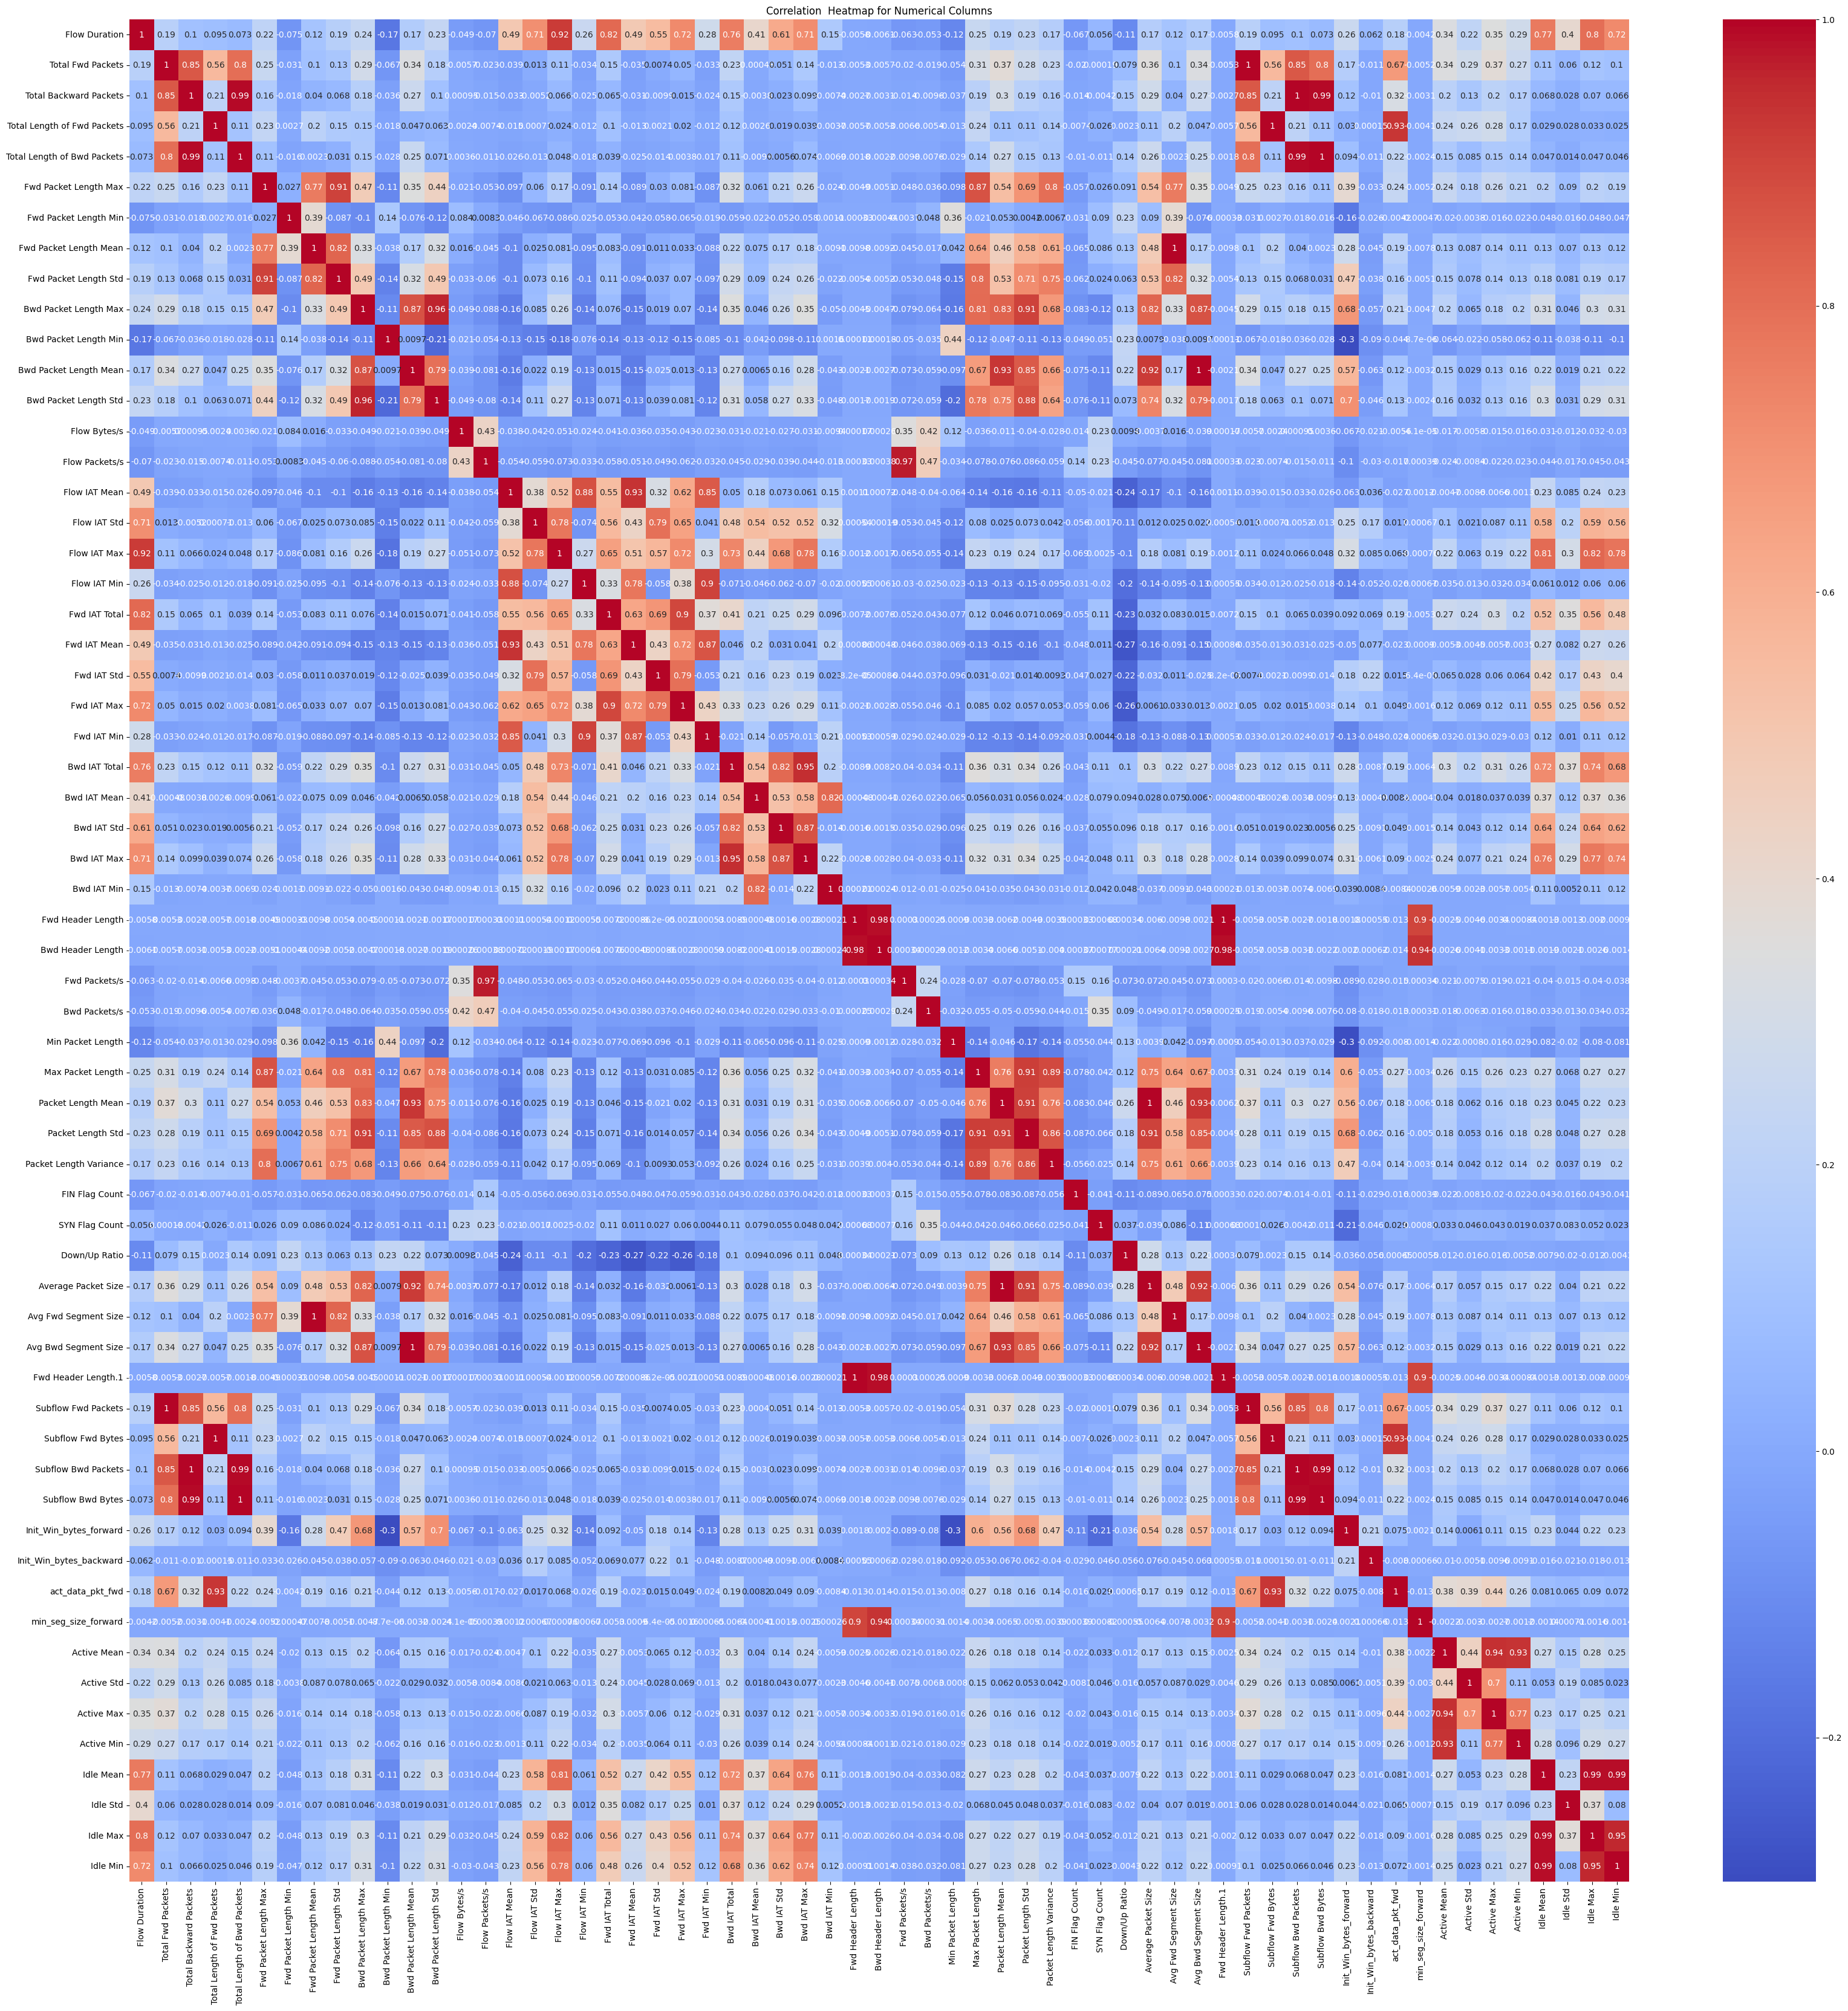

In [147]:
def calculate_correlation_matrix(df, cols):


# Create a matrix with unique references for each row
  corr_matrix = pd.DataFrame(index=cols, columns=cols)

  # Calculate Cramér's V only for upper triangular matrix
  for i, col1 in enumerate(cols):
      for j, col2 in enumerate(cols):
          if j == i :
            corr_matrix.loc[col1, col2] = 1.0
          elif j > i:
            mean1 = df[col1].mean()
            mean2 = df[col2].mean()

            covariance = ((df[col1] - mean1) * (df[col2] - mean2)).mean()

            std_dev1 = df[col1].std()
            std_dev2 = df[col2].std()

            correlation = covariance / (std_dev1 * std_dev2)

            corr_matrix.loc[col1, col2]= correlation
            corr_matrix.loc[col2, col1] = correlation
  return corr_matrix

corr_matrix = calculate_correlation_matrix(processed_ransomware_df, numerical_cols)
corr_matrix = corr_matrix.astype(float)
# print(type(corr_matrix))
# print(  corr_matrix.head())
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation  Heatmap for Numerical Columns")
plt.show()

In [148]:
def find_high_correlation_pairs(corr_matrix, threshold=0.97):
    """
    Parameters:
        corr_matrix (pd.DataFrame): The correlation matrix.
        threshold (float): The correlation threshold to identify high correlations.

    Returns:
        list: A list of tuples containing the column pairs with correlation greater than the threshold.
    """
    high_corr_pairs = []

    # Iterate through the upper triangle of the correlation matrix
    for i, col1 in enumerate(corr_matrix.columns):
        for j, col2 in enumerate(corr_matrix.columns):
            if i >= j:
                continue  # Skip the diagonal and lower triangle
            if col1 != col2 and corr_matrix.loc[col1, col2] > threshold:
                high_corr_pairs.append((col1, col2))

    return high_corr_pairs


threshold = 0.97
high_corr_pairs = find_high_correlation_pairs(corr_matrix, threshold)
print(f"Pairs of columns with correlation greater than {threshold}:")
for pair in high_corr_pairs:
    print(pair)


Pairs of columns with correlation greater than 0.97:
('Total Fwd Packets', 'Subflow Fwd Packets')
('Total Backward Packets', 'Total Length of Bwd Packets')
('Total Backward Packets', 'Subflow Bwd Packets')
('Total Backward Packets', 'Subflow Bwd Bytes')
('Total Length of Fwd Packets', 'Subflow Fwd Bytes')
('Total Length of Bwd Packets', 'Subflow Bwd Packets')
('Total Length of Bwd Packets', 'Subflow Bwd Bytes')
('Fwd Packet Length Mean', 'Avg Fwd Segment Size')
('Bwd Packet Length Mean', 'Avg Bwd Segment Size')
('Flow Packets/s', 'Fwd Packets/s')
('Fwd Header Length', 'Bwd Header Length')
('Fwd Header Length', 'Fwd Header Length.1')
('Bwd Header Length', 'Fwd Header Length.1')
('Packet Length Mean', 'Average Packet Size')
('Subflow Bwd Packets', 'Subflow Bwd Bytes')
('Idle Mean', 'Idle Max')
('Idle Mean', 'Idle Min')


In [149]:
for pair in high_corr_pairs:
    print(pair)

('Total Fwd Packets', 'Subflow Fwd Packets')
('Total Backward Packets', 'Total Length of Bwd Packets')
('Total Backward Packets', 'Subflow Bwd Packets')
('Total Backward Packets', 'Subflow Bwd Bytes')
('Total Length of Fwd Packets', 'Subflow Fwd Bytes')
('Total Length of Bwd Packets', 'Subflow Bwd Packets')
('Total Length of Bwd Packets', 'Subflow Bwd Bytes')
('Fwd Packet Length Mean', 'Avg Fwd Segment Size')
('Bwd Packet Length Mean', 'Avg Bwd Segment Size')
('Flow Packets/s', 'Fwd Packets/s')
('Fwd Header Length', 'Bwd Header Length')
('Fwd Header Length', 'Fwd Header Length.1')
('Bwd Header Length', 'Fwd Header Length.1')
('Packet Length Mean', 'Average Packet Size')
('Subflow Bwd Packets', 'Subflow Bwd Bytes')
('Idle Mean', 'Idle Max')
('Idle Mean', 'Idle Min')


In [150]:

for col in processed_ransomware_df.columns:
  print(col)

Source Port
Destination Port
Protocol
Timestamp
Flow Duration
Total Fwd Packets
Total Backward Packets
Total Length of Fwd Packets
Total Length of Bwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Min Packet Length
Max Packet Length
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
Down/Up Ratio
Average Packet Size
Avg Fwd Segment Size
Avg Bwd Segment Size
Fwd Header Length.1
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
Init_Win_bytes_forward
Init_Win_byt

In [151]:
cols_to_be_dropped = ['Subflow Fwd Packets', 'Subflow Bwd Packets','Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Packets/s', 'Fwd Header Length.1', 'Average Packet Size', 'Idle Max', 'Idle Min']
# print(type(processed_ransomware_df))

  # numerical_cols.remove(col)
processed_ransomware_df.drop(columns=cols_to_be_dropped,inplace=True)

for col in cols_to_be_dropped:
  numerical_cols.remove(col)

print('Ransomware Columns')
for col in processed_ransomware_df.columns:
  print(col)

Ransomware Columns
Source Port
Destination Port
Protocol
Timestamp
Flow Duration
Total Fwd Packets
Total Backward Packets
Total Length of Fwd Packets
Total Length of Bwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Fwd Header Length
Bwd Header Length
Bwd Packets/s
Min Packet Length
Max Packet Length
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
Down/Up Ratio
Subflow Fwd Bytes
Init_Win_bytes_forward
Init_Win_bytes_backward
act_data_pkt_fwd
min_seg_size_forward
Active Mean
Active Std
Active Max
Active Min
Idle Mean
Idle Std
Label
Source_IP_type


In [153]:

print('Ransomware Columns')
for col in processed_ransomware_df.columns:
  print(col)

Ransomware Columns
Source Port
Destination Port
Protocol
Timestamp
Flow Duration
Total Fwd Packets
Total Backward Packets
Total Length of Fwd Packets
Total Length of Bwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Fwd Header Length
Bwd Header Length
Bwd Packets/s
Min Packet Length
Max Packet Length
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
Down/Up Ratio
Subflow Fwd Bytes
Init_Win_bytes_forward
Init_Win_bytes_backward
act_data_pkt_fwd
min_seg_size_forward
Active Mean
Active Std
Active Max
Active Min
Idle Mean
Idle Std
Label
Source_IP_type


In [176]:
print(categorical_cols)

if('Label' in categorical_cols):
  categorical_cols.remove('Label')
if('Source Port' in categorical_cols):
  categorical_cols.remove('Source Port')
if('Destination Port' in categorical_cols):
  categorical_cols.remove('Destination Port')
print(categorical_cols)

['Fwd PSH Flags', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Source_IP_type_private', 'Source_IP_type_public', 'Destination_IP_type_public', 'Destination_IP_type_private', 'Destination_IP_type_multicast', 'Protocol_TCP', 'Protocol_Reserved', 'Protocol_UDP']
['Fwd PSH Flags', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Source_IP_type_private', 'Source_IP_type_public', 'Destination_IP_type_public', 'Destination_IP_type_private', 'Destination_IP_type_multicast', 'Protocol_TCP', 'Protocol_Reserved', 'Protocol_UDP']


In [175]:
#one hot encode categorical cols
def OneHotEncode(df, cols) :
  new_col_names = []
  for col in cols :
    unique = df[col].unique()
    for u in unique :
      new_col_name = col + '_' + str(u)
      new_col_names.append(new_col_name)
      df[new_col_name] = (df[col] == u).astype(int)
    df.drop(col, axis =1,inplace=True)
  return new_col_names

categorical_cols_ec = OneHotEncode(processed_ransomware_df,categorical_cols)
print(processed_ransomware_df.head(10))

   Source Port  Destination Port         Timestamp  Flow Duration  Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std   Flow Bytes/s  Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd Header Length  Bwd Header Length  Bwd Packets/s  Min Packet Length  Max Packet Length  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  SYN Flag Count  Down/Up Ratio  Subflow Fwd Bytes  Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  min_seg_size_forward  Active Mean  Active Std  Active Max  Active Min  Idle Mean  Idle Std   Label  Fwd PSH Flags_0  Fwd PSH Flags_1  P

In [182]:
# categorical_cols.extend(categorical_cols_ec)
# if('Source_IP_type' in categorical_cols):
#   categorical_cols.remove('Source_IP_type')
# if('Destination_IP_type' in categorical_cols):
#   categorical_cols.remove('Destination_IP_type')
# if('Protocol' in categorical_cols):
#   categorical_cols.remove('Protocol')
# # categorical_cols.extend(['Source_IP_type_private',  'Source_IP_type_public'  ,'Destination_IP_type_public','Destination_IP_type_private','Destination_IP_type_multicast', 'Protocol_TCP', 'Protocol_Reserved', 'Protocol_UDP'])
# # print(categorical_cols)
print(categorical_cols_ec)

['Fwd PSH Flags_0', 'Fwd PSH Flags_1', 'PSH Flag Count_1', 'PSH Flag Count_0', 'ACK Flag Count_0', 'ACK Flag Count_1', 'URG Flag Count_0', 'URG Flag Count_1', 'Source_IP_type_private_1', 'Source_IP_type_private_0', 'Source_IP_type_public_0', 'Source_IP_type_public_1', 'Destination_IP_type_public_1', 'Destination_IP_type_public_0', 'Destination_IP_type_private_0', 'Destination_IP_type_private_1', 'Destination_IP_type_multicast_0', 'Destination_IP_type_multicast_1', 'Protocol_TCP_1', 'Protocol_TCP_0', 'Protocol_Reserved_0', 'Protocol_Reserved_1', 'Protocol_UDP_0', 'Protocol_UDP_1']


In [180]:
def train_test_split(df, test_size=0.2, random_state=None):

    # Randomly shuffle and sample the test set
    test_df = df.sample(frac=test_size, random_state=random_state)

    # Use the remaining data as the training set
    train_df = df.drop(test_df.index)

    return train_df, test_df

train_df, test_df = train_test_split(processed_ransomware_df, test_size=0.2, random_state=42)
print(train_df.shape)
print(test_df.shape)

(313627, 79)
(78407, 79)


In [192]:
trainsummary_df = pd.DataFrame(summarize_dataframe(train_df))

display(HTML(trainsummary_df.to_html(max_rows=100, max_cols=None)))

In [201]:


def prep_columns(df, categorical_cols=[], numerical_cols=[]):
    # Initialize dictionary to store mean and std of each column
    column_stats = {}
    temp_df = pd.DataFrame()
    # Step 1: Handle numerical columns (scale them to mean 0, std 1)
    for col in numerical_cols:
        mean = df[col].mean()
        std = df[col].std()
        column_stats[col] = {'mean': mean, 'std': std}

        # Standardize numerical variables
        temp_df[col] = (df[col] - mean) / std

    # Step 2: Handle categorical columns (calculate modal probabilities)
    for col in categorical_cols:
        # Calculate frequency distribution (probability) of each category
        mean = df[col].eq(1).sum() / len(df)

        column_stats[col] = {'mean': mean,  'std': None}  # No std for categorical columns
        newval = (df[col] - mean) / mean
        # newval = newval.where(newval <= 1, 1)
        temp_df[col] = newval
    # Return the modified dataframe and column stats
    return temp_df, column_stats




# Perform FAMD and store column-wise statistics
modified_train_df, column_stats = prep_columns(train_df, categorical_cols_ec, numerical_cols)
import json
file_path = '/content/drive/MyDrive/MLP/column_stats.json'

with open(file_path, "w") as json_file:
    json.dump(column_stats, json_file, indent=4)

print("Modified DataFrame:")
print(modified_train_df.head(5))

print("\nColumn-wise Statistics (Mean and Std):")
print(column_stats)


Modified DataFrame:
   Flow Duration  Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd Header Length  Bwd Header Length  Bwd Packets/s  Min Packet Length  Max Packet Length  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  SYN Flag Count  Down/Up Ratio  Subflow Fwd Bytes  Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  min_seg_size_forward  Active Mean  Active Std  Active Max  Active Min  Idle Mean  Idle Std  Fwd PSH Flags_0  Fwd PSH Flags_1  PSH Flag Count_1  PSH Flag Count_0  ACK

printing 1
[ 1.43328151e+02  1.10039898e+02  2.03103128e+01  1.52888257e+01
  1.20040397e+01  9.02833960e+00  6.20572338e+00  4.39709278e+00
  3.03627977e+00  2.91922824e+00  2.75343805e+00  2.33539295e+00
  2.06611862e+00  1.85458054e+00  1.65164426e+00  1.58636235e+00
  1.49100915e+00  1.12427713e+00  1.06446675e+00  1.02302809e+00
  9.80305230e-01  7.77480253e-01  7.13972916e-01  6.34343767e-01
  5.38866421e-01  4.59248673e-01  4.45370024e-01  3.76749708e-01
  3.25427160e-01  2.96548175e-01  2.73525516e-01  2.48803377e-01
  1.97188142e-01  1.73909430e-01  1.08435603e-01  9.64968031e-02
  9.34639927e-02  6.83233691e-02  6.92765927e-02  6.42096388e-02
  4.61196038e-02  4.42245207e-02  3.35469091e-02  2.37953627e-02
  1.89212329e-02  1.74433805e-02  1.29390438e-02  1.15051284e-02
  8.91411967e-03  7.26976067e-03  4.51605416e-04  1.10488264e-03
  1.40681531e-03  1.71394869e-03  5.12188396e-03  4.53336489e-03
  4.16693729e-03  2.91171091e-03 -1.81770102e-14  3.62886740e-15
  4.63527426e-

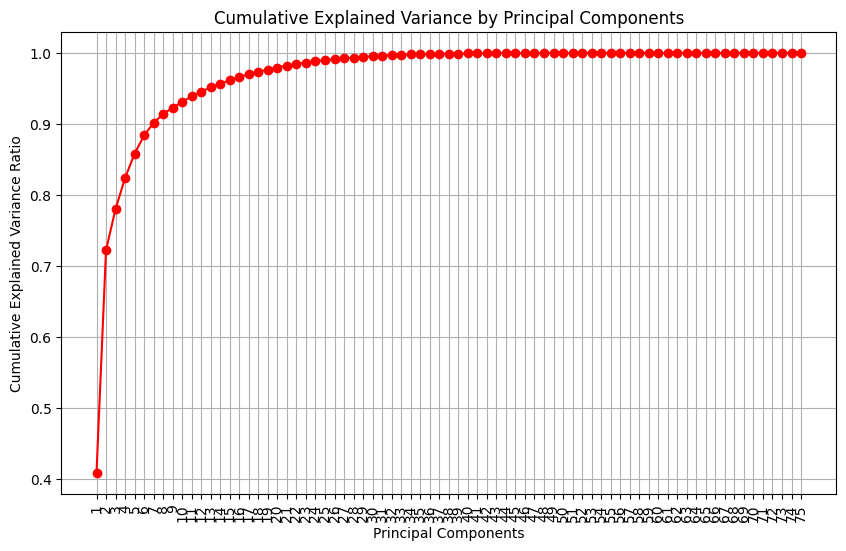

In [241]:

def famd_transform(df):

    n = len(df)
    # Step 1: Covariance matrix calculation using les
    covariance_matrix = df.T @ df / n  # Covariance using x.T @ x / n

    # Step 2: Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    # print("printing 1")
    # print(eigenvalues)
    # Step 3: Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    # print(sorted_indices)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # print("printing 2")
    # print(eigenvectors)
    loadings = eigenvectors* eigenvalues

    loadings_df = pd.DataFrame(
        loadings,
        columns=[f"FAMD_Component_{i+1}" for i in range(len(df.columns))],
        index=df.columns
    )
    # Return transformed data, loadings, and principal components
    return  eigenvalues, eigenvectors, loadings_df

def transform_data(df, eigenvectors, k_components ):

    selected_eigenvectors = eigenvectors[:, :k_components]

    # Project the data onto the principal components
    transformed_data = np.dot(df, selected_eigenvectors)

    # Step 7: Convert to DataFrames for easier interpretation
    transformed_df = pd.DataFrame(
        transformed_data,
        columns=[f"FAMD_Component_{i+1}" for i in range(k_components)],
        # index=df.index
    )

    return transformed_df

eigenvalues, eigenvector, loadings_df = famd_transform(modified_train_df)



# Total variance is the sum of all eigenvalues
total_variance = np.sum(eigenvalues)

# Calculate the variance explained by each principal component
explained_variance_ratio = eigenvalues / total_variance

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)
print(cumulative_variance)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xticks(range(1, len(cumulative_variance) + 1), rotation=90)  # For better x-axis labels
plt.grid(True)
plt.show()
# transformed_df = transform_data(modified_train_df, eigenvector, 2)

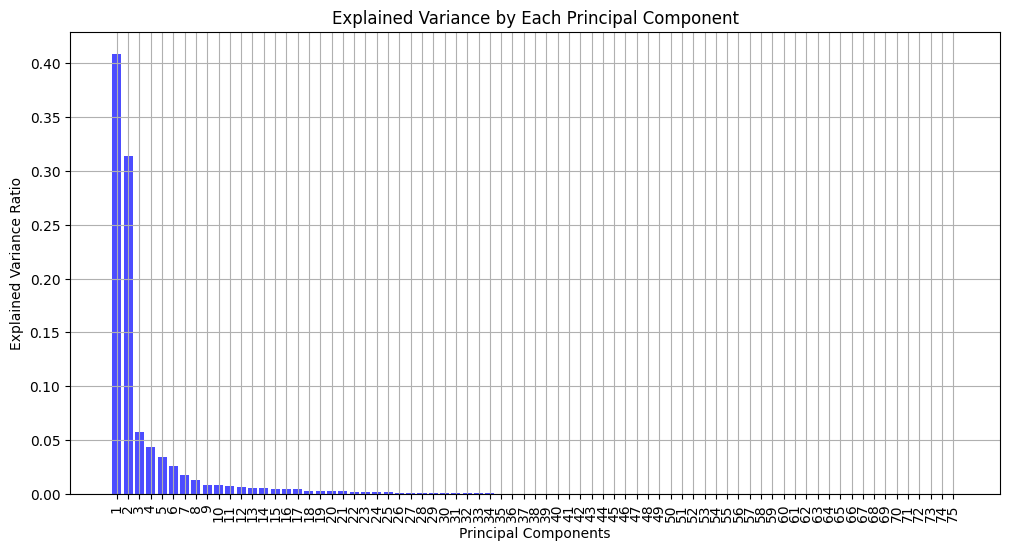

In [236]:
 # Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, color='blue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1), rotation=90)  # For better x-axis labels
plt.grid(True)
plt.show()

In [230]:
transform_training_df = transform_data(modified_train_df, eigenvector, 20)
print(transform_training_df.head())

   FAMD_Component_1  FAMD_Component_2  FAMD_Component_3  FAMD_Component_4  FAMD_Component_5  FAMD_Component_6  FAMD_Component_7  FAMD_Component_8  FAMD_Component_9  FAMD_Component_10  FAMD_Component_11  FAMD_Component_12  FAMD_Component_13  FAMD_Component_14  FAMD_Component_15  FAMD_Component_16  FAMD_Component_17  FAMD_Component_18  FAMD_Component_19  FAMD_Component_20
0         -1.244443         -1.189613         -4.211399         -1.002003          2.088020         -1.994310         -3.196144         -0.721897         -0.922282          -0.017253           0.838063          -0.076870          -0.073903           0.123015           0.677169          -0.070264          -0.065389          -0.333319          -0.149411          -0.164534
1         -1.220071         -1.244580          2.431445         -8.257373         -9.139794          1.087746         -2.076543         -0.097392          0.412636           0.014611          -0.401036           0.120327          -0.119528           0.50

In [231]:
print(transform_training_df.columns)

Index(['FAMD_Component_1', 'FAMD_Component_2', 'FAMD_Component_3',
       'FAMD_Component_4', 'FAMD_Component_5', 'FAMD_Component_6',
       'FAMD_Component_7', 'FAMD_Component_8', 'FAMD_Component_9',
       'FAMD_Component_10', 'FAMD_Component_11', 'FAMD_Component_12',
       'FAMD_Component_13', 'FAMD_Component_14', 'FAMD_Component_15',
       'FAMD_Component_16', 'FAMD_Component_17', 'FAMD_Component_18',
       'FAMD_Component_19', 'FAMD_Component_20'],
      dtype='object')


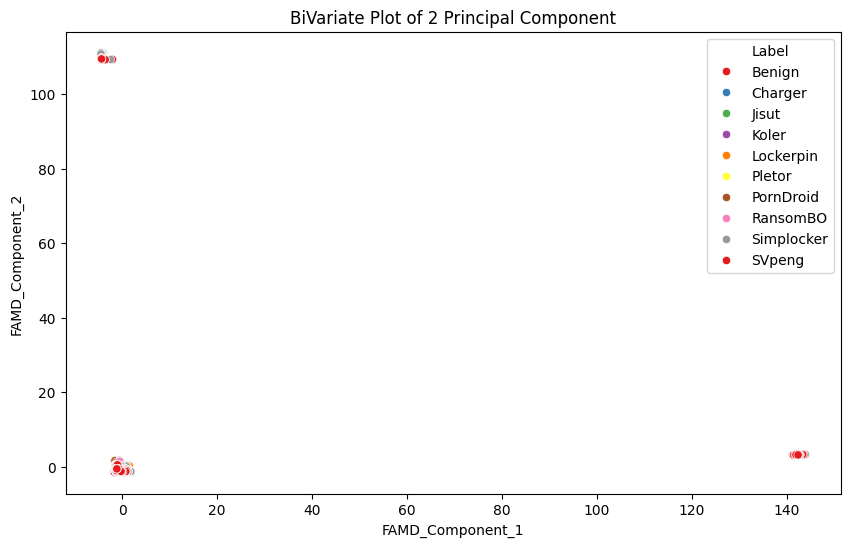

In [242]:
plot_df = transform_training_df[['FAMD_Component_1', 'FAMD_Component_2', 'FAMD_Component_3']]
plot_df['Label'] = train_df['Label']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='FAMD_Component_1', y='FAMD_Component_2', hue='Label', palette=ransomware_palette)
plt.xlabel('FAMD_Component_1')
plt.ylabel('FAMD_Component_2')
plt.title('BiVariate Plot of 2 Principal Component')
# plt.xticks(range(1, len(explained_variance_ratio) + 1))  # For better x-axis labels
# plt.grid(True)
plt.show()

NameError: name 'df' is not defined

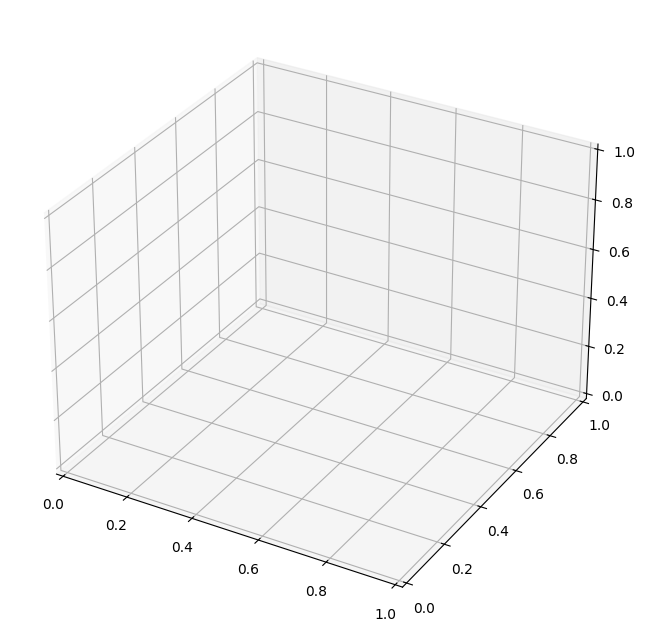

In [243]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Mapping labels to colors (you can use your own color map or palette)
unique_labels =  df['Label'].unique()
colors = ['r', 'g', 'b']  # Assign a color for each label

# Plot each class with different colors
for i, label in enumerate(unique_labels):
    subset = df[df['Label'] == label]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], label=plot_df['Label'], c=colors[i], s=50, alpha=0.6)

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of First 3 Principal Components')

# Show legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
_

# numerical_cols = [item for item in processed_ransomware_df if item not in categorical_cols]
# numerical_cols.remove('Timestamp')
# # print(numerical_cols)
# print (numerical_cols)
# #'winter':'blue', 'fall': 'red', 'spring':'orange', 'summer':'green'
# # data_df = day_df[numerical + ['season']]
# # data_df['season'] = data_df['season'].map({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})
# g =sns.pairplot(processed_ransomware_df, vars=numerical_cols, diag_kind='auto', hue= 'Label',kind = 'reg',palette = ransomware_palette, corner=True)
# g.fig.suptitle("Numerical Features RelationShip With Season")
# plt.show()